# <span style = 'color:purple'> Imports & Settings

#### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

from lib.pca import *

%reload_ext autoreload
%autoreload 2

In [2]:
import random
random.seed(6)
np.random.seed(6)
os.environ['PYTHONHASHSEED'] = str(6)

#### Settings

In [3]:
data_source = 'all'

scaler_type = "minmax" # Can be "standard", "robust", "minmax" or None
scale_by_year = True

perform_PCA = True
autodetermine_n_PCA = False
target_explained_variance = 0.9
n_PCA_specified = 13 
limit_PCA = True # If True, will rebuild the PCA matrix with only the 5 most impacting features per PC
reproduce_ke_error = True

#### Constants

In [4]:
RAW_DATA_PATH = Path('./raw_data')
PREPROC_DATA_PATH = Path('./preproc_data')
REPRO_PATH = Path('./repro_data')

In [5]:
if data_source == 'manual' :
    filename = 'Ke_all_data_manual_selected.xlsx'
else :
    filename = 'Ke_all_data.xlsx'

### Intermediate check function

In [6]:
def intermediate_check(data:pd.DataFrame, step:int):
    check_path = Path('./repro_data')
    try :
        ref = pd.read_csv(check_path / f"step_{step}.csv", index_col='PLAYER')
    except :
        ref = pd.read_csv(check_path / f"step_{step}.csv", index_col='Unnamed: 0')
    
    if 'PLAYER' in ref.columns :
        ref.set_index('PLAYER', inplace=True)
    if data.equals(ref) or np.allclose(data.values, ref.values,):
        print("Data exactly matches the intermediate step")
        return None
    else :
        print("Data does not exactly match")
        return pd.DataFrame(data = np.abs(data - ref), index = data.index, columns=data.columns) < 0.0000001 
        
    

# <span style = 'color:cyan'> Data

### Loading

In [7]:
base_df = pd.read_excel(RAW_DATA_PATH / filename,index_col = "PLAYER").sort_index()

initial_n_players = base_df.shape[0]
base_df.rename(columns={'YEAR':'Year'}, inplace=True)
base_df

,Year,advanced_OFFRTG,advanced_DEFRTG,advanced_NETRTG,advanced_AST%,advanced_AST/TO,advanced_AST Ratio,advanced_OREB%,advanced_DREB%,advanced_REB%,...,use_%DREB,use_%REB,use_%AST,use_%TOV,use_%STL,use_%BLK,use_%BLKA,use_%PF,use_%PFD,use_%PTS
PLAYER,,,,,,,,,,,,,,,,,,,,,
_2000_A.C. Green,2000,105.3,97.0,8.3,5.8,1.51,14.2,8.0,16.0,12.0,...,24.2,25.6,8.7,10.5,19.1,7.7,14.0,16.8,1.9,10.4
_2000_A.J. Bramlett,2000,82.5,113.1,-30.7,0.0,0.00,0.0,14.1,18.9,15.9,...,27.0,31.9,0.0,12.5,7.7,0.0,20.0,31.0,5.7,7.1
_2000_Aaron McKie,2000,97.5,95.9,1.5,20.2,2.12,23.8,2.3,10.1,6.1,...,16.3,13.8,28.0,17.6,29.1,10.8,14.4,19.4,0.8,17.1
_2000_Aaron Williams,2000,103.9,102.3,1.7,6.2,0.73,8.6,10.6,16.2,13.5,...,26.4,29.9,8.3,16.2,17.0,51.4,24.6,26.1,1.9,19.4
_2000_Adam Keefe,2000,97.3,100.7,-3.4,9.3,0.74,15.0,8.4,16.5,12.5,...,24.7,26.6,12.5,20.4,18.9,20.3,27.3,28.9,1.8,11.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
_2022_Zach LaVine,2022,112.5,113.4,-0.9,20.7,1.77,16.7,1.0,12.1,6.7,...,17.4,15.2,25.3,28.3,11.9,12.2,27.1,14.0,31.9,30.1
_2022_Zavier Simpson,2022,98.6,125.1,-26.5,25.0,3.00,31.9,1.0,11.4,5.8,...,17.6,14.0,40.5,21.3,19.2,25.0,25.0,22.4,14.8,12.6
_2022_Zeke Nnaji,2022,107.2,110.4,-3.2,3.7,0.74,6.6,7.7,14.1,10.7,...,19.8,24.6,4.6,11.1,13.4,25.5,22.1,21.9,19.0,17.5


In [8]:
base_df.index.value_counts()

dupl_pl = base_df.index.value_counts()[base_df.index.value_counts() > 1].index.tolist()
print(dupl_pl)
base_df = base_df[base_df.index.isin(dupl_pl) == False]
base_df.shape

['_2013_Chris Johnson', '_2009_Marcus Williams', '_2008_Marcus Williams']


(10439, 71)

In [9]:
columns_renamer = {col : col.split('.')[1] for col in base_df.columns if col.find('.')>=0}
base_df.rename(columns = columns_renamer,inplace=True)
if data_source == 'manual':
    base_df.drop(columns = 'per_game_MIN', inplace=True)


/tmp/ipykernel_9589/100369449.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df.rename(columns = columns_renamer,inplace=True)


In [10]:
base_df.columns

Index(['Year', 'advanced_OFFRTG', 'advanced_DEFRTG', 'advanced_NETRTG',
       'advanced_AST%', 'advanced_AST/TO', 'advanced_AST Ratio',
       'advanced_OREB%', 'advanced_DREB%', 'advanced_REB%',
       'advanced_TO Ratio', 'advanced_eFG%', 'advanced_TS%', 'advanced_USG%',
       'advanced_PACE', 'advanced_PIE', 'advanced_POSS', 'defense_DEF RTG',
       'defense_DREB', 'defense_DREB%', 'defense_%DREB', 'defense_STL',
       'defense_STL%', 'defense_BLK', 'defense_%BLK', 'defense_OPP PTSOFF TOV',
       'defense_OPP PTS2ND CHANCE', 'defense_OPP PTSFB',
       'defense_OPP PTSPAINT', 'defense_DEFWS', 'per_game_MIN', 'per_game_PTS',
       'per_game_FGM', 'per_game_FGA', 'per_game_FG%', 'per_game_3PM',
       'per_game_3PA', 'per_game_3P%', 'per_game_FTM', 'per_game_FTA',
       'per_game_FT%', 'per_game_OREB', 'per_game_DREB', 'per_game_REB',
       'per_game_AST', 'per_game_TOV', 'per_game_STL', 'per_game_BLK',
       'per_game_PF', 'per_game_FP', 'per_game_DD2', 'per_game_TD3',
     

In [11]:
base_df = base_df.dropna()

In [12]:
check = intermediate_check(base_df, 0)

Data exactly matches the intermediate step


### Scaling

In [13]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
sc_dict = {"standard" : StandardScaler, "robust" : RobustScaler, "minmax":MinMaxScaler}

column_names = list(base_df.columns)
index_values = list(base_df.index)

if scaler_type is not None :
    if scale_by_year:
        scaled_data_by_year = {}
        yrs = base_df['Year'].unique()
        for i in yrs:
            data = base_df[base_df["Year"] == i].to_numpy()
            scaler = sc_dict[scaler_type]()
            scaler.fit(data)
            scaled_data = scaler.transform(data)
            scaled_data_by_year[i] = scaled_data
        df_scaled = pd.DataFrame(data = np.concatenate([scaled_data_by_year[i] for i in yrs]),
                                        index = index_values,
                                        columns = column_names).drop(columns=['Year'])
    else :
        data = base_df.values
        scaler = sc_dict[scaler_type]()
        scaler.fit(data)
        scaled_data = scaler.transform(data)
        df_scaled = pd.DataFrame(data = scaled_data,
                                        index = index_values,
                                        columns = column_names).drop(columns=['Year'])
df_scaled

,advanced_OFFRTG,advanced_DEFRTG,advanced_NETRTG,advanced_AST%,advanced_AST/TO,advanced_AST Ratio,advanced_OREB%,advanced_DREB%,advanced_REB%,advanced_TO Ratio,...,use_%DREB,use_%REB,use_%AST,use_%TOV,use_%STL,use_%BLK,use_%BLKA,use_%PF,use_%PFD,use_%PTS
_2000_A.C. Green,0.875969,0.521661,0.759259,0.127193,0.188750,0.314159,0.459770,0.503145,0.547945,0.2350,...,0.466281,0.525667,0.157895,0.1680,0.19100,0.098465,0.140,0.323077,0.171171,0.297143
_2000_A.J. Bramlett,0.581395,0.812274,0.445250,0.000000,0.000000,0.000000,0.810345,0.594340,0.726027,0.3125,...,0.520231,0.655031,0.000000,0.2000,0.07700,0.000000,0.200,0.596154,0.513514,0.202857
_2000_Aaron McKie,0.775194,0.501805,0.704509,0.442982,0.265000,0.526549,0.132184,0.317610,0.278539,0.2800,...,0.314066,0.283368,0.508167,0.2816,0.29100,0.138107,0.144,0.373077,0.072072,0.488571
_2000_Aaron Williams,0.857881,0.617329,0.706119,0.135965,0.091250,0.190265,0.609195,0.509434,0.616438,0.2950,...,0.508671,0.613963,0.150635,0.2592,0.17000,0.657289,0.246,0.501923,0.171171,0.554286
_2000_Adam Keefe,0.772610,0.588448,0.665056,0.203947,0.092500,0.331858,0.482759,0.518868,0.570776,0.5100,...,0.475915,0.546201,0.226860,0.3264,0.18900,0.259591,0.273,0.555769,0.162162,0.340000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
_2022_Zach LaVine,0.819288,0.788961,0.606529,0.207000,0.147500,0.376126,0.034965,0.311054,0.205521,0.1880,...,0.248571,0.212885,0.253000,0.2830,0.14875,0.122000,0.271,0.220126,0.478261,0.414030
_2022_Zavier Simpson,0.698523,0.915584,0.459908,0.250000,0.250000,0.718468,0.034965,0.293059,0.177914,0.2120,...,0.251429,0.196078,0.405000,0.2130,0.24000,0.250000,0.250,0.352201,0.221889,0.173315
_2022_Zeke Nnaji,0.773241,0.756494,0.593356,0.037000,0.061667,0.148649,0.269231,0.362468,0.328221,0.1800,...,0.282857,0.344538,0.046000,0.1110,0.16750,0.255000,0.221,0.344340,0.284858,0.240715
_2022_Ziaire Williams,0.822763,0.739177,0.635739,0.062000,0.132500,0.265766,0.059441,0.182519,0.134969,0.1480,...,0.144286,0.130252,0.083000,0.1060,0.18000,0.064000,0.100,0.336478,0.142429,0.210454


In [14]:
df_tmp = df_scaled.copy()
df_tmp['na'] = df_tmp.isna().any(axis = 1)
na_inds = df_tmp[df_tmp['na']].index
base_df.loc[na_inds][['per_game_MIN', 'per_game_PTS','per_game_REB', 'per_game_AST']]

,per_game_MIN,per_game_PTS,per_game_REB,per_game_AST


In [15]:
df_scaled = df_scaled.dropna(axis= 0)
df_scaled.shape

(10429, 70)

In [16]:
check = intermediate_check(df_scaled, 1)

Data exactly matches the intermediate step


# <span style = "color:orange">Clustering

### PCA

In [17]:
from sklearn.decomposition import PCA

if perform_PCA:
    pca = PCA()
    pca.fit(df_scaled.values)
    W = pca.components_

    W = pd.DataFrame(W.T,
                    index=df_scaled.columns,
                    columns=[f'PC{i}' for i in range(1, df_scaled.shape[1]+1)])
    display(W)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70
advanced_OFFRTG,0.063158,-0.006046,-0.024170,-0.103518,0.284648,-0.215010,0.252172,-0.170055,0.169139,-0.102419,...,0.003641,0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00
advanced_DEFRTG,0.010341,0.005174,-0.099410,0.049169,-0.396462,-0.043617,0.007269,-0.107208,0.321173,-0.104540,...,-0.002260,-3.766525e-01,1.515967e-01,1.790684e-01,5.096412e-01,-4.819261e-02,1.507941e-02,2.804101e-02,1.743112e-01,9.813789e-02
advanced_NETRTG,0.034792,-0.009704,0.042246,-0.084801,0.422937,-0.176121,0.198309,-0.124453,0.006970,-0.040080,...,-0.013613,1.154632e-14,6.522560e-16,-3.566591e-15,-9.714451e-16,-1.717376e-15,-4.145989e-15,-5.780099e-15,-2.414735e-15,-5.467848e-15
advanced_AST%,0.088262,0.117466,0.085795,0.320277,0.127144,0.103563,-0.181471,0.067454,0.148628,0.060096,...,0.019302,2.069178e-14,1.545639e-15,-2.817191e-15,-1.249244e-13,1.477594e-14,1.707022e-14,-7.419195e-15,-3.095354e-14,7.246807e-15
advanced_AST/TO,0.034578,0.102378,-0.044087,0.149111,0.137322,0.069829,-0.169032,0.012947,0.076101,0.078239,...,-0.005658,-8.004014e-15,-1.132341e-15,2.301544e-15,2.143945e-14,2.731647e-15,-1.452777e-15,-3.282368e-15,-2.209604e-15,-7.091333e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
use_%BLK,-0.026592,-0.214129,-0.026981,-0.072763,0.020270,-0.028353,0.062423,0.349513,0.182476,0.324406,...,-0.000432,-3.475076e-01,1.489442e-01,-6.686879e-02,-3.459663e-01,-2.540903e-01,-1.832661e-01,-1.900667e-01,2.680591e-01,-1.635865e-01
use_%BLKA,0.024671,-0.054509,0.163355,0.058721,-0.049402,-0.000041,0.107127,0.008854,-0.064606,-0.015342,...,0.003736,6.383782e-16,-8.222589e-16,-4.891920e-16,1.238593e-15,1.484923e-15,-4.371503e-16,-1.637579e-15,2.003606e-16,-5.551115e-17
use_%PF,-0.069830,-0.089994,0.054672,0.003375,0.008328,-0.010374,0.097286,0.006918,0.102791,0.092434,...,0.009270,-4.260481e-15,-3.413936e-15,2.579046e-16,-2.365469e-14,3.073930e-15,2.147696e-15,2.550044e-15,1.610691e-15,3.049644e-15
use_%PFD,0.063100,-0.067598,0.217980,0.043706,0.074293,-0.085571,0.284324,-0.030705,0.187750,0.071948,...,0.002199,-1.429412e-15,-1.304512e-15,1.871767e-15,-1.794398e-14,7.355228e-16,1.734723e-16,-5.551115e-17,2.307182e-15,2.844947e-16


In [18]:
if perform_PCA and autodetermine_n_PCA:
    n_PCA = find_n_PC(pca.explained_variance_ratio_, target_explained_variance)
else :
    n_PCA = n_PCA_specified
n_PCA = min(n_PCA, df_scaled.shape[1])
print(n_PCA)

13


In [19]:

if perform_PCA:
    final_PCA = PCA(n_components=n_PCA)
    final_PCA.fit(df_scaled.values)    
    final_W = final_PCA.components_

    final_W = pd.DataFrame(final_W.T,
                    index=df_scaled.columns,
                    columns=[f'PC_{i}' for i in range(1, n_PCA+1)])
    display(final_W)


,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13
advanced_OFFRTG,0.063158,-0.006046,-0.024170,-0.103518,0.284648,-0.215010,0.252172,-0.170055,0.169139,-0.102419,0.145056,-0.214787,-0.304235
advanced_DEFRTG,0.010341,0.005174,-0.099410,0.049169,-0.396462,-0.043617,0.007269,-0.107208,0.321173,-0.104540,0.000381,-0.213060,0.051666
advanced_NETRTG,0.034792,-0.009704,0.042246,-0.084801,0.422937,-0.176121,0.198309,-0.124453,0.006970,-0.040080,0.236604,-0.107295,-0.238433
advanced_AST%,0.088262,0.117466,0.085795,0.320277,0.127144,0.103563,-0.181471,0.067454,0.148628,0.060096,0.034463,-0.004857,-0.083535
advanced_AST/TO,0.034578,0.102378,-0.044087,0.149111,0.137322,0.069829,-0.169032,0.012947,0.076101,0.078239,-0.110913,-0.008135,-0.000873
...,...,...,...,...,...,...,...,...,...,...,...,...,...
use_%BLK,-0.026592,-0.214129,-0.026981,-0.072763,0.020270,-0.028353,0.062423,0.349513,0.182476,0.324406,-0.003912,-0.108064,0.018504
use_%BLKA,0.024671,-0.054509,0.163355,0.058721,-0.049402,-0.000041,0.107127,0.008854,-0.064606,-0.015342,-0.036711,0.029461,-0.067904
use_%PF,-0.069830,-0.089994,0.054672,0.003375,0.008328,-0.010374,0.097286,0.006918,0.102791,0.092434,0.225906,0.084430,0.191173
use_%PFD,0.063100,-0.067598,0.217980,0.043706,0.074293,-0.085571,0.284324,-0.030705,0.187750,0.071948,-0.268251,0.436638,-0.022275


In [20]:
# To reproduce Ke & al. 
if limit_PCA and perform_PCA:
    
    mask = np.abs(final_W).rank(axis = 0, ascending = False) <=5
    PCA_matrix_ltd = final_W[mask].fillna(0)
    display(PCA_matrix_ltd)

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13
advanced_OFFRTG,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.252172,0.000000,0.000000,0.000000,0.000000,-0.214787,-0.304235
advanced_DEFRTG,0.0,0.0,0.000000,0.000000,-0.396462,0.0,0.000000,0.000000,0.321173,0.000000,0.000000,-0.213060,0.000000
advanced_NETRTG,0.0,0.0,0.000000,0.000000,0.422937,0.0,0.000000,0.000000,0.000000,0.000000,0.236604,0.000000,-0.238433
advanced_AST%,0.0,0.0,0.000000,0.320277,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
advanced_AST/TO,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
use_%BLK,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.349513,0.000000,0.324406,0.000000,0.000000,0.000000
use_%BLKA,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
use_%PF,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
use_%PFD,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.284324,0.000000,0.000000,0.000000,-0.268251,0.436638,0.000000


In [21]:
if limit_PCA and perform_PCA :
    check = intermediate_check(PCA_matrix_ltd.T, 3)

Data does not exactly match


#### Investigate discrepencies in PCA_matrix

In [22]:
PCA_matrix_ltd.T

,advanced_OFFRTG,advanced_DEFRTG,advanced_NETRTG,advanced_AST%,advanced_AST/TO,advanced_AST Ratio,advanced_OREB%,advanced_DREB%,advanced_REB%,advanced_TO Ratio,...,use_%DREB,use_%REB,use_%AST,use_%TOV,use_%STL,use_%BLK,use_%BLKA,use_%PF,use_%PFD,use_%PTS
PC_1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
PC_2,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-0.244674,0.000000,-0.2476,0.000000,...,0.000000,-0.252112,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
PC_3,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.267723
PC_4,0.000000,0.000000,0.000000,0.320277,0.0,0.313653,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.333802,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
PC_5,0.000000,-0.396462,0.422937,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
PC_6,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.256554,0.0000,0.000000,...,0.254111,0.000000,0.000000,0.000000,0.270914,0.000000,0.0,0.0,0.000000,0.000000
PC_7,0.252172,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.392857,0.000000,0.0,0.0,0.284324,0.000000
PC_8,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.349513,0.0,0.0,0.000000,0.000000
PC_9,0.000000,0.321173,0.000000,0.000000,0.0,0.234093,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.203363,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
PC_10,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.324406,0.0,0.0,0.000000,0.000000


In [23]:
pd.read_csv(REPRO_PATH / 'step_3.csv', index_col= "Unnamed: 0")

,advanced_OFFRTG,advanced_DEFRTG,advanced_NETRTG,advanced_AST%,advanced_AST/TO,advanced_AST Ratio,advanced_OREB%,advanced_DREB%,advanced_REB%,advanced_TO Ratio,...,use_%DREB,use_%REB,use_%AST,use_%TOV,use_%STL,use_%BLK,use_%BLKA,use_%PF,use_%PFD,use_%PTS
PC_1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
PC_2,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-0.244674,0.000000,-0.2476,0.000000,...,0.0,-0.252112,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
PC_3,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.267723
PC_4,0.000000,0.000000,0.000000,0.320277,0.0,0.313653,0.000000,0.000000,0.0000,0.000000,...,0.0,0.000000,0.333802,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
PC_5,0.000000,-0.396462,0.422937,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
PC_6,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.256554,0.0000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.270914,0.000000,0.0,0.0,0.000000,0.000000
PC_7,0.252172,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.392857,0.000000,0.0,0.0,0.284324,0.000000
PC_8,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.349513,0.0,0.0,0.000000,0.000000
PC_9,0.000000,0.321173,0.000000,0.000000,0.0,0.234093,0.000000,0.000000,0.0000,0.000000,...,0.0,0.000000,0.203363,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
PC_10,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.324406,0.0,0.0,0.000000,0.000000


In [24]:
diff_cols = check.T[check.sum() != check.shape[0]].index


In [25]:
PCA_matrix_ltd.T[diff_cols]

,advanced_DEFRTG,defense_DEF RTG,defense_%DREB,defense_STL,per_game_STL,use_%DREB
PC_1,0.000000,0.000000,0.0,0.0,0.000000,0.000000
PC_2,0.000000,0.000000,0.0,0.0,0.000000,0.000000
PC_3,0.000000,0.000000,0.0,0.0,0.000000,0.000000
PC_4,0.000000,0.000000,0.0,0.0,0.000000,0.000000
PC_5,-0.396462,-0.396462,0.0,0.0,0.000000,0.000000
PC_6,0.000000,0.000000,0.0,0.0,0.000000,0.254111
PC_7,0.000000,0.000000,0.0,0.0,0.000000,0.000000
PC_8,0.000000,0.000000,0.0,0.0,0.000000,0.000000
PC_9,0.321173,0.321173,0.0,0.0,0.000000,0.000000
PC_10,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [26]:
pd.read_csv(REPRO_PATH / 'step_3.csv', index_col= "Unnamed: 0")[diff_cols]

,advanced_DEFRTG,defense_DEF RTG,defense_%DREB,defense_STL,per_game_STL,use_%DREB
PC_1,0.000000,0.000000,0.000000,0.000000,0.0,0.0
PC_2,0.000000,0.000000,0.000000,0.000000,0.0,0.0
PC_3,0.000000,0.000000,0.000000,0.000000,0.0,0.0
PC_4,0.000000,0.000000,0.000000,0.000000,0.0,0.0
PC_5,-0.396462,-0.396462,0.000000,0.000000,0.0,0.0
PC_6,0.000000,0.000000,0.254111,0.000000,0.0,0.0
PC_7,0.000000,0.000000,0.000000,0.000000,0.0,0.0
PC_8,0.000000,0.000000,0.000000,0.000000,0.0,0.0
PC_9,0.321173,0.321173,0.000000,0.000000,0.0,0.0
PC_10,0.000000,0.000000,0.000000,0.000000,0.0,0.0


#### Projection

In [46]:
if perform_PCA :
    if limit_PCA :
        X_proj = df_scaled.dot(PCA_matrix_ltd)
    else :
        X_proj = final_PCA.transform(df_scaled.values)
        X_proj = pd.DataFrame(X_proj, index = df_scaled.index, columns=[f'PC{i+1}' for i in range(n_PCA)])
else :
    X_proj = df_scaled

X_proj

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13
_2000_A.C. Green,0.513648,-0.516553,0.313239,0.184267,0.313657,0.480144,0.474990,0.609412,0.509672,-0.476251,0.406789,-0.363223,0.087533
_2000_A.J. Bramlett,0.112613,-0.723136,0.360306,0.000000,-0.302239,0.478878,0.517259,0.224021,0.726163,-0.223485,0.315050,-0.089301,-0.077687
_2000_Aaron McKie,0.562238,-0.070316,0.571184,0.109991,0.282452,0.400448,0.521360,0.629333,0.644502,-0.442688,0.399368,-0.330838,0.142070
_2000_Aaron Williams,0.440310,-0.635464,0.640128,0.149643,0.107549,0.482764,0.463105,1.093677,0.552072,-0.207506,0.492076,-0.323470,-0.024922
_2000_Adam Keefe,0.171423,-0.545905,0.435476,0.241271,0.074738,0.489576,0.430954,0.683138,0.553507,-0.333444,0.557401,-0.230431,-0.046223
...,...,...,...,...,...,...,...,...,...,...,...,...,...
_2022_Zach LaVine,0.964281,-0.011735,0.758398,0.022210,-0.043345,0.303366,0.596005,0.678918,0.816324,-0.514521,0.220885,-0.250753,0.053288
_2022_Zavier Simpson,0.902052,-0.091401,0.346948,0.400751,-0.531477,0.344301,0.555342,0.592217,0.997487,-0.255672,0.227564,-0.187424,-0.211416
_2022_Zeke Nnaji,0.367835,-0.317034,0.353505,-0.037253,-0.049994,0.348619,0.543521,0.818440,0.699354,-0.473684,0.288182,-0.315618,0.024792
_2022_Ziaire Williams,0.540322,-0.002443,0.323966,-0.058890,0.033057,0.227846,0.547561,0.607576,0.750849,-0.520528,0.227481,-0.416378,0.077218


In [28]:
check = intermediate_check(X_proj, 4)

Data exactly matches the intermediate step


### Clustering

In [48]:
X_clust = X_proj.values

if reproduce_ke_error :
    kmeans = KMeans(n_clusters=10, random_state=0)
    labels = kmeans.fit_predict(X_proj)
    X_ke = X_proj.copy()
    X_ke["clusters"] = labels
    X_ke_clust = X_ke.values
    print(X_ke_clust.shape, X_clust.shape)

(10429, 14) (10429, 13)


In [55]:
k_min = 2
k_max = 15

clustering_methods = {
    'kmeans' : KMeans,
    'agglomerative': AgglomerativeClustering    
}

scores = []

for k in range(k_min,k_max):
    for name, object in clustering_methods.items():
        correct_clustering = object(n_clusters= k) if name == 'kmeans' else object(n_clusters= k, linkage= 'ward')
        y_pred = correct_clustering.fit_predict(X_clust)
        correct_labels = correct_clustering.labels_
        scores.append({'k': k, 'method': name, 'type': 'ARO', 'silhouette': silhouette_score(X_clust, correct_labels) if k >1 else 0})         
        if reproduce_ke_error :
            incorrect_clustering = object(n_clusters= k) if name == 'kmeans' else object(n_clusters= k, linkage= 'ward')
            y_pred = incorrect_clustering.fit_predict(X_ke_clust)
            incorrect_labels = incorrect_clustering.labels_
            scores.append({'k': k, 'method': name, 'type': 'Disclosed', 'silhouette': silhouette_score(X_ke_clust, incorrect_labels) if k >1 else 0})         
            scores.append({'k': k, 'method': name, 'type': 'Restated', 'silhouette': silhouette_score(X_clust, incorrect_labels) if k >1 else 0})

scores_df = pd.DataFrame(scores)
scores_df.head()

,k,method,type,silhouette
0,2,kmeans,ARO,0.176218
1,2,kmeans,Disclosed,0.596950
2,2,kmeans,Restated,0.037462
3,2,agglomerative,ARO,0.150373
4,2,agglomerative,Disclosed,0.519596


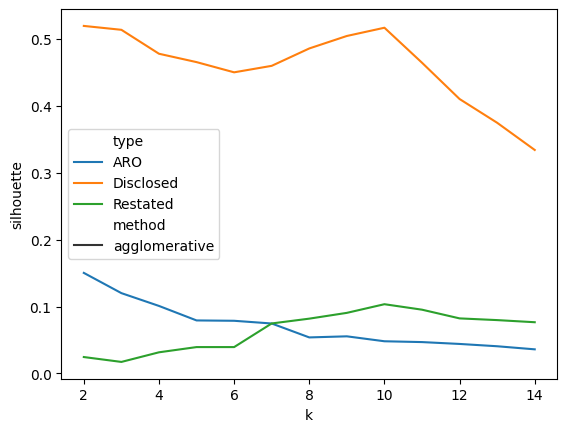

In [57]:
sns.lineplot(data=scores_df[scores_df['method']=='agglomerative'], x='k',y='silhouette',hue = 'type', style= 'method');         